In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image, plotting

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
#Fixing seed for reproducibility
#np.random.seed(0)

In [27]:
#Loading data
from nilearn import datasets

adhd_data = datasets.fetch_adhd(n_subjects=40)

In [28]:
adhd_data.keys()

## “func” features the paths to the rs-fMRI data images; 
## “confounds” are the CSV files containing the nuisance variables (confounds) we want to be aware of as not to affect our analysis; 
## “phenotypic” provides explanations for the preprocessing steps; 
## “description” is, well, description of the dataset.

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [6]:
#Getting the functional files
func = adhd_data.func
print(func[0])

/Users/larissapassine/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


In [29]:
#Using nilearn's individual component analysis for group level
from nilearn import decomposition

canica = decomposition.CanICA(n_components=20, mask_strategy='background')
canica.fit(func)

CanICA(mask_strategy='background')

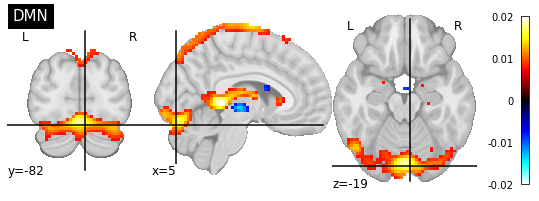

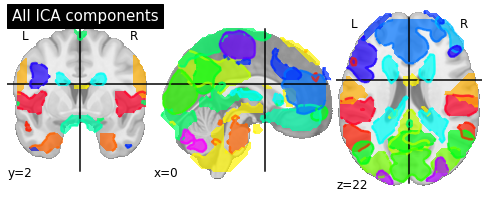

In [33]:
#Retrieving the components
components = canica.components_

#Using a masker to project into the 3D space
components_img = canica.masker_.inverse_transform(components)

#Plotting the default mode network (DMN) without region extraction
plotting.plot_stat_map(image.index_img(components_img, 9), title='DMN')
plotting.show()

#Plotting all the components
plotting.plot_prob_atlas(components_img, title='All ICA components')
plotting.show()

In [42]:
smith_atlas = datasets.fetch_atlas_smith_2009()
smith_atlas_rs_networks = smith_atlas.rsn20

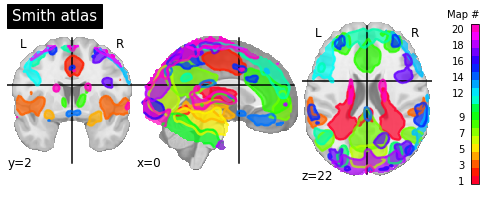

In [34]:
plotting.plot_prob_atlas(smith_atlas_rs_networks, 
                         title='Smith atlas',  
                         colorbar=True)
plotting.show()

In [32]:
#Using a filter to extract the regions time series 
from nilearn import input_data
masker_smith = input_data.NiftiMapsMasker(smith_atlas_rs_networks, smoothing_fwhm=6,
                         standardize=False, detrend=True,
                         t_r=2.5, low_pass=0.1,
                         high_pass=0.01)



#Computing the regions signals and extracting the phenotypic information of interest
subjects_smith = []
adhds_smith = []
sites_smith = []
labels_smith = []
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker_smith.fit_transform(func_file, confounds=confound_file)
    subjects_smith.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd == 1:
        adhds_smith.append(time_series)    
    sites_smith.append(phenotypic['site'])
    labels_smith.append(phenotypic['adhd'])

In [43]:
#Using a filter to extract the regions time series 

masker_ICA = input_data.NiftiMapsMasker(components_img, smoothing_fwhm=6,
                         standardize=False, detrend=True,
                         t_r=2.5, low_pass=0.1,
                         high_pass=0.01)



#Computing the regions signals and extracting the phenotypic information of interest
subjects_ICA = []
adhds_ICA = []
sites_ICA = []
labels_ICA = []
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker_ICA.fit_transform(func_file, confounds=confound_file)
    subjects_ICA.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd == 1:
        adhds_ICA.append(time_series)    
    sites_ICA.append(phenotypic['site'])
    labels_ICA.append(phenotypic['adhd'])

In [44]:
#Comparing the three types of functional connectivity between the regions of interest
from nilearn.connectome import ConnectivityMeasure

connectivity_biomarkers_smith = {}

kinds_smith = ['correlation', 'partial correlation', 'tangent']
for kind_smith in kinds_smith:
    conn_measure_smith = ConnectivityMeasure(kind=kind_smith, vectorize=True)
    connectivity_biomarkers_smith[kind_smith] = conn_measure_smith.fit_transform(subjects_smith)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers_smith['correlation'].shape[1]))

210 correlation biomarkers for each subject.


In [45]:
#Comparing the three types of functional connectivity between the regions of interest


connectivity_biomarkers_ICA = {}

kinds_ICA = ['correlation', 'partial correlation', 'tangent']
for kind_ICA in kinds_ICA:
    conn_measure_ICA = ConnectivityMeasure(kind=kind_ICA, vectorize=True)
    connectivity_biomarkers_ICA[kind_ICA] = conn_measure_ICA.fit_transform(subjects_ICA)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers_ICA['correlation'].shape[1]))

210 correlation biomarkers for each subject.


In [47]:
#Stratifying the data to use for comparison

from sklearn.model_selection import StratifiedKFold

classes_smith = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(sites_smith, labels_smith)]
cv_smith = StratifiedKFold(n_splits=3)

In [48]:
#Stratifying the data to use for comparison


classes_ICA = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(sites_ICA, labels_ICA)]
cv_ICA = StratifiedKFold(n_splits=3)

In [50]:
#Classifying using the connectivity coefficients and linear support vector
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

mean_scores_smith = []
for kind in kinds_smith:
    svc_smith = LinearSVC(random_state=0)
    cv_scores_smith = cross_val_score(svc_smith,
                                connectivity_biomarkers_smith[kind_smith],
                                y=labels_smith,
                                cv=cv_smith,
                                groups=labels_smith,
                                scoring='accuracy',
                                )
    mean_scores_smith.append(cv_scores_smith.mean())

In [51]:
#Classifying using the connectivity coefficients and linear support vector

mean_scores_ICA = []
for kind in kinds_ICA:
    svc_ICA = LinearSVC(random_state=0)
    cv_scores_ICA = cross_val_score(svc,
                                connectivity_biomarkers_ICA[kind_ICA],
                                y=labels_ICA,
                                cv=cv_ICA,
                                groups=labels_ICA,
                                scoring='accuracy',
                                )
    mean_scores_ICA.append(cv_scores_ICA.mean())

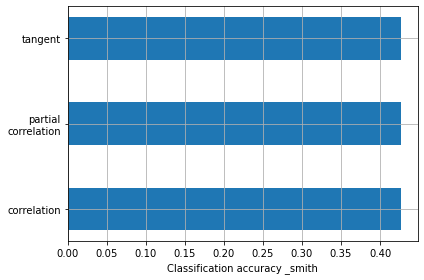

In [53]:
#Visualizing results and accuracy
from nilearn.plotting import show

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds_smith)) * .1 + .1
plt.barh(positions, mean_scores_smith, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds_smith]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy _smith')
plt.grid(True)
plt.tight_layout()

show()

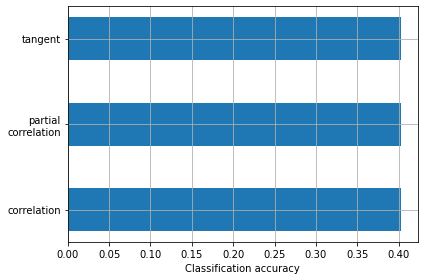

In [54]:
#Visualizing results and accuracy

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds_ICA)) * .1 + .1
plt.barh(positions, mean_scores_ICA, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds_ICA]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()

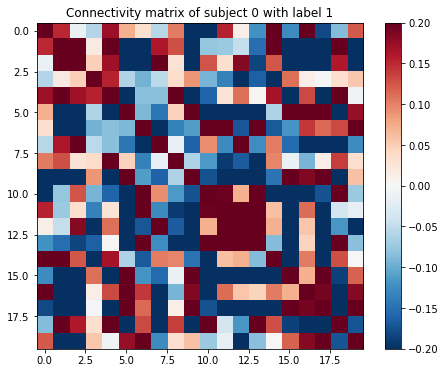

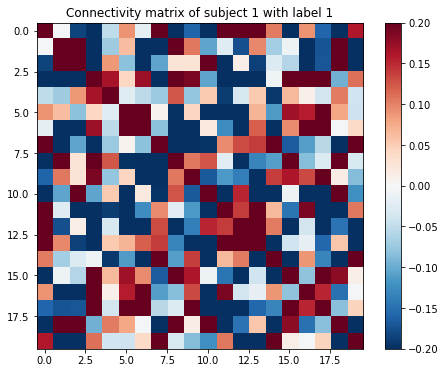

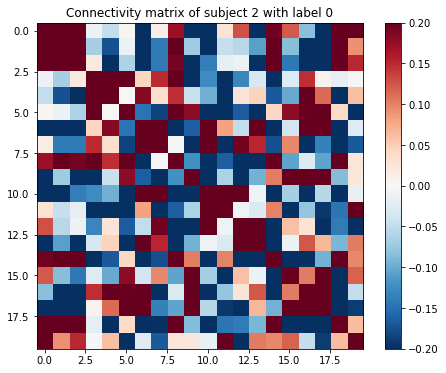

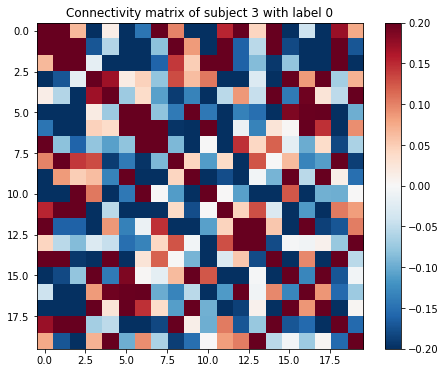

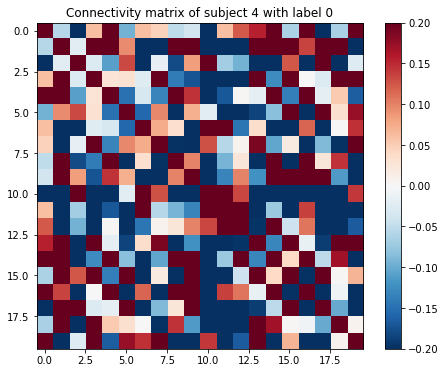

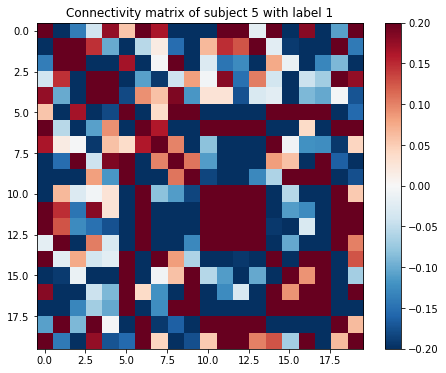

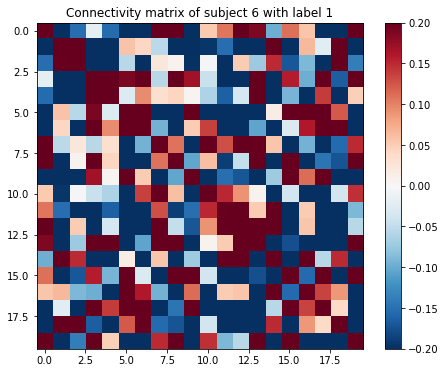

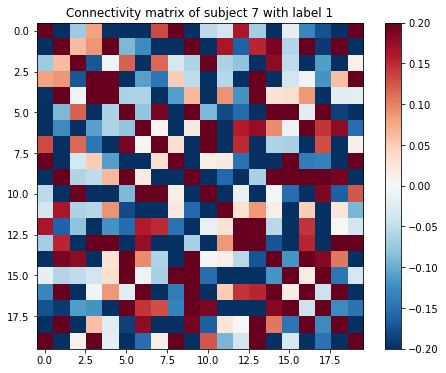

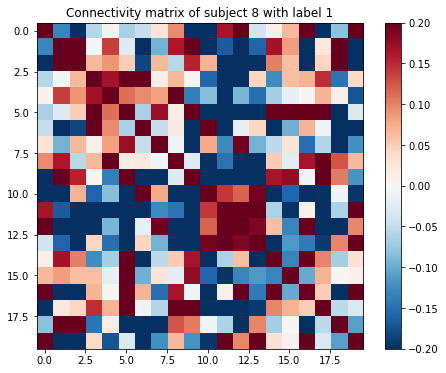

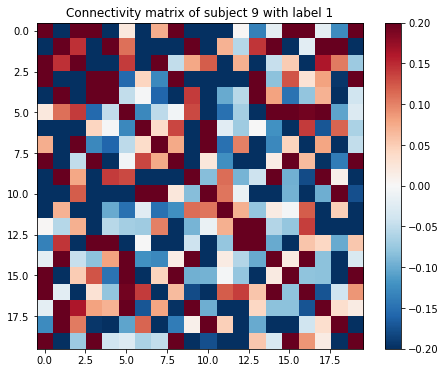

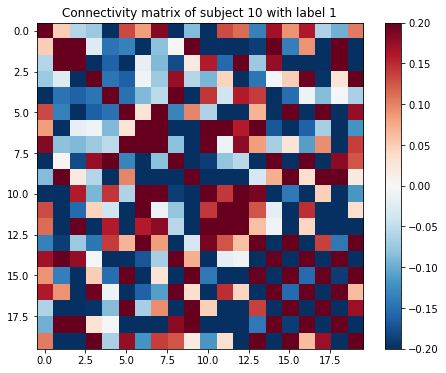

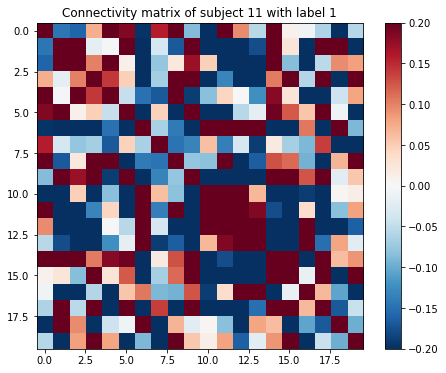

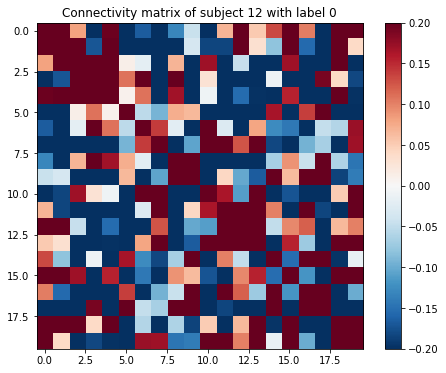

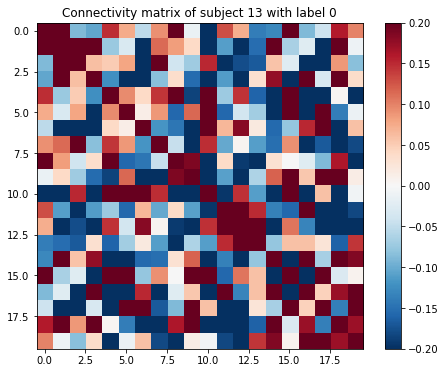

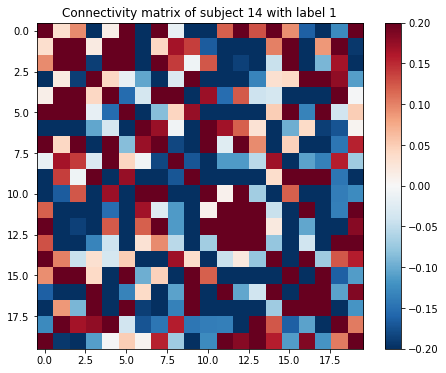

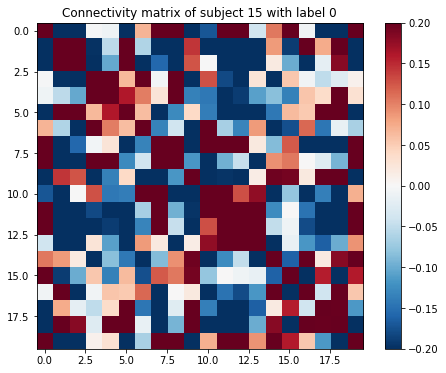

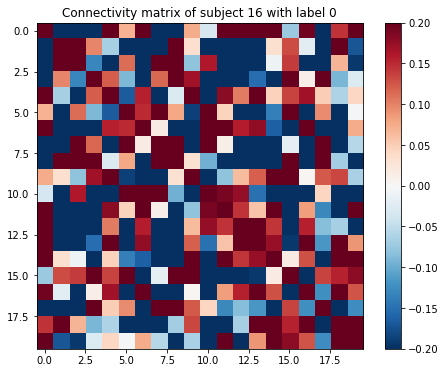

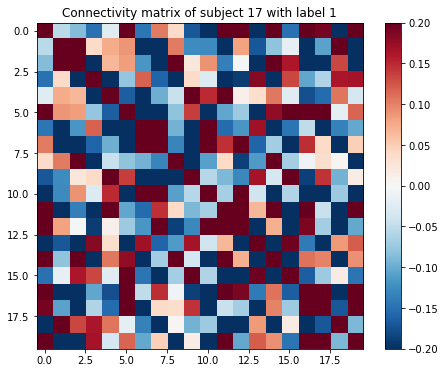

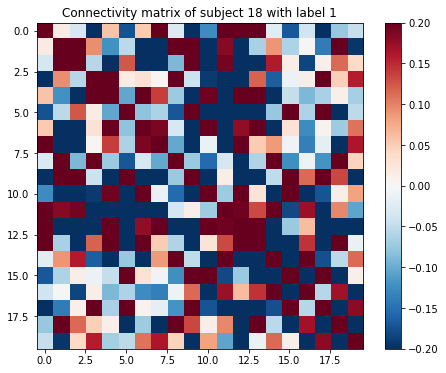

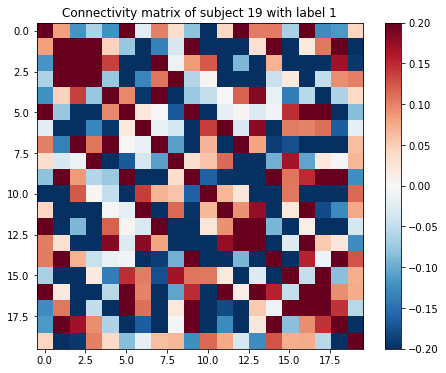

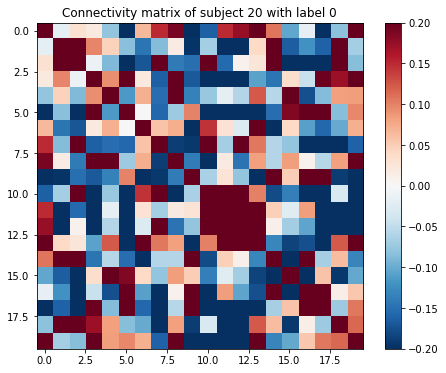

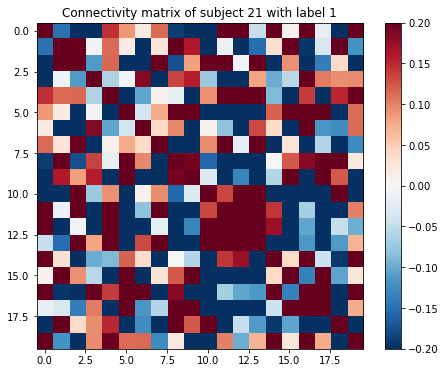

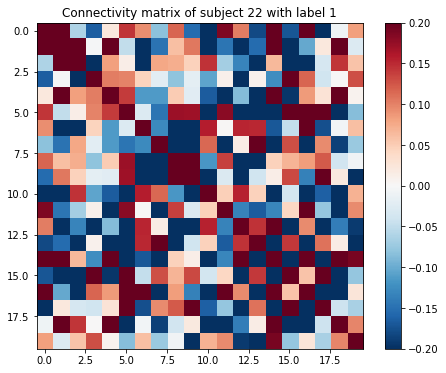

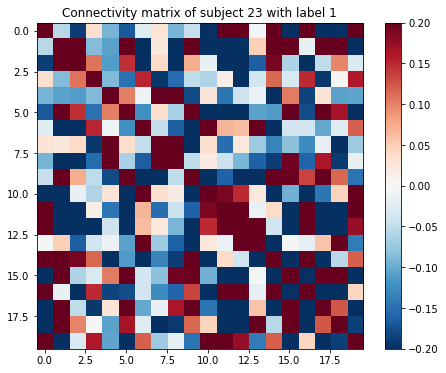

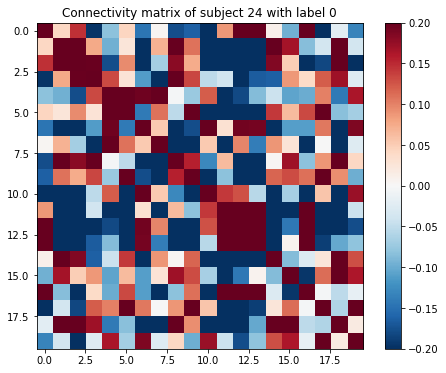

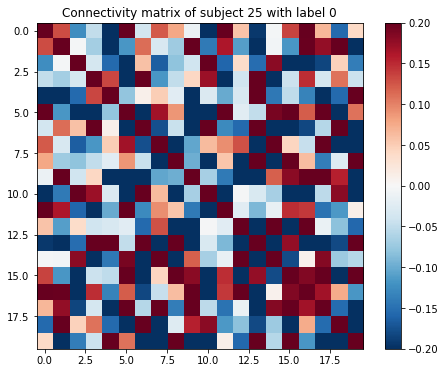

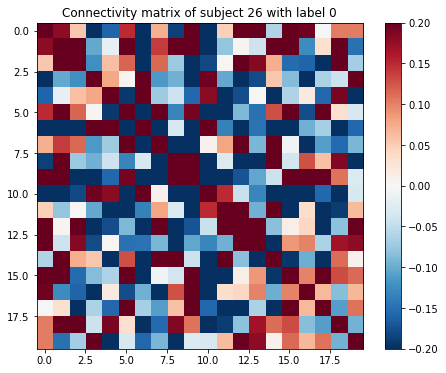

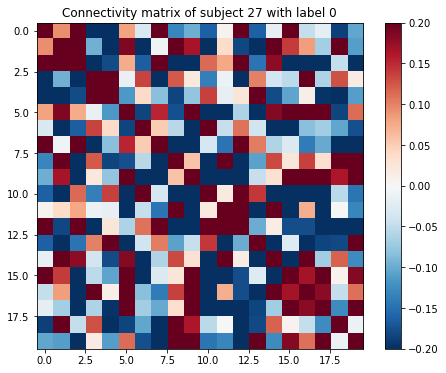

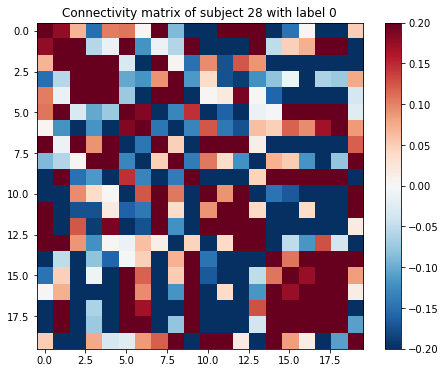

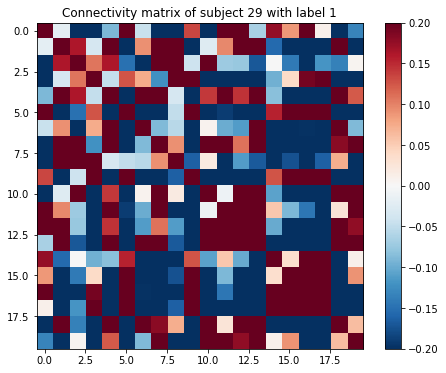

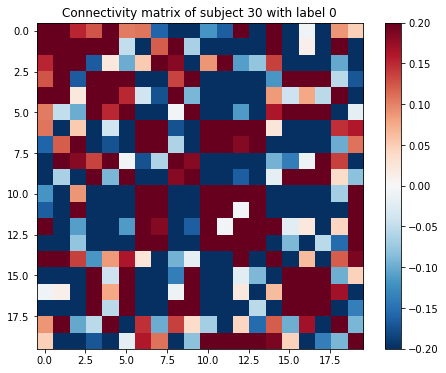

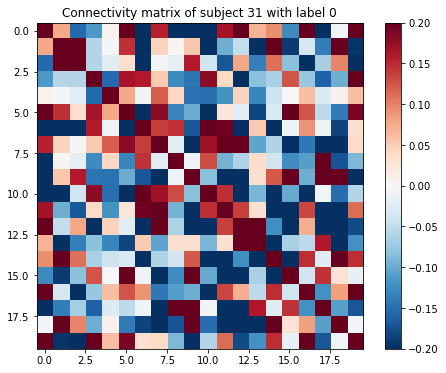

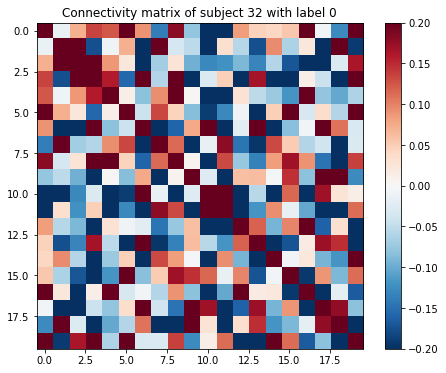

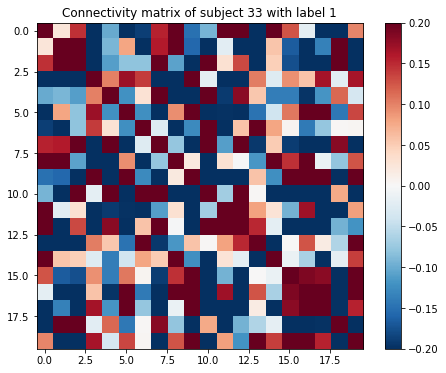

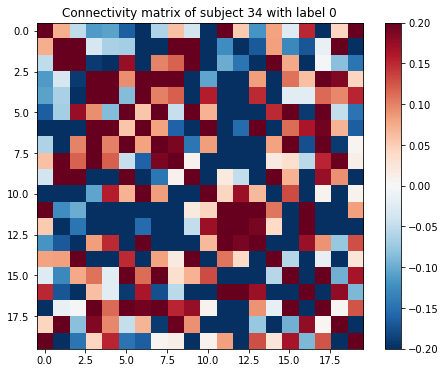

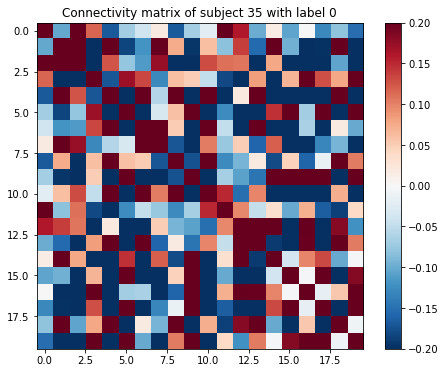

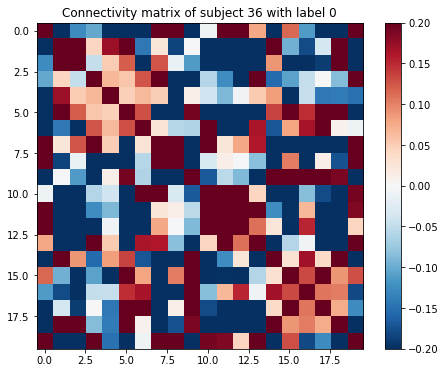

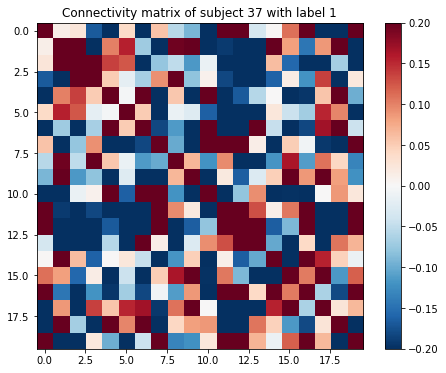

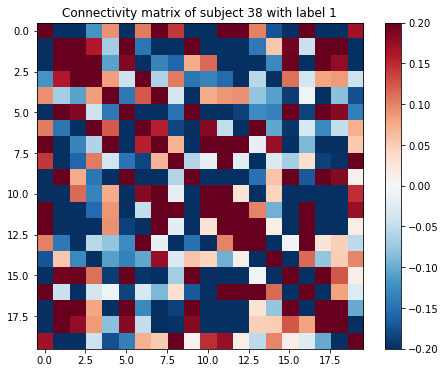

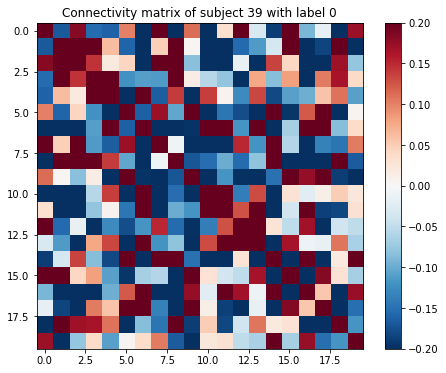

In [14]:
#Displaying the connectomes for the most accurate kind of functional connectivity
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(subjects)


for i in range(40):
    plt.figure(figsize=(8,6))
    plt.imshow(correlation_matrices[i], vmax=.20, vmin=-.20, cmap='RdBu_r')
    plt.colorbar()
    plt.title('Connectivity matrix of subject {} with label {}'.format(i, labels[i]))

In [15]:
#Separating the correlation matrices between treatment and control subjects
adhd_correlations = []
control_correlations = []
for i in range(40):
    if labels[i] == 1:
        adhd_correlations.append(correlation_matrices[i])
    else:
        control_correlations.append(correlation_matrices[i])

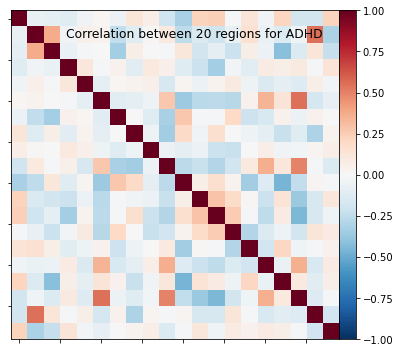

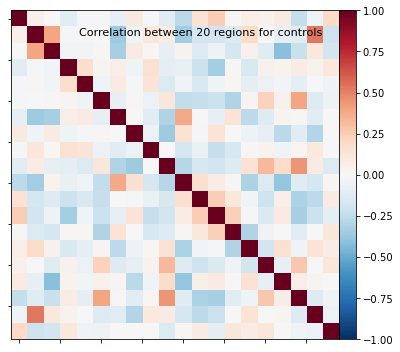

In [16]:
#Getting the mean correlation matrix across all treatment subjects
mean_correlations_adhd = np.mean(adhd_correlations, axis=0).reshape(time_series.shape[-1],
                                                          time_series.shape[-1])

#Getting the mean correlation matrix across all control subjects
mean_correlations_control = np.mean(control_correlations, axis=0).reshape(time_series.shape[-1],
                                                          time_series.shape[-1])

#Visualizing the mean correlation
plotting.plot_matrix(mean_correlations_adhd, vmax=1, vmin=-1,
                               colorbar=True, title='Correlation between 20 regions for ADHD')

plotting.plot_matrix(mean_correlations_control, vmax=1, vmin=-1,
                               colorbar=True, title='Correlation between 20 regions for controls')

#Getting the center coordinates from the component decomposition to use as atlas labels
coords = plotting.find_probabilistic_atlas_cut_coords(smith_atlas_rs_networks)

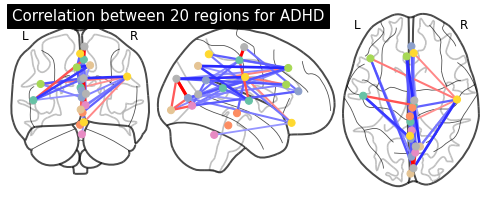

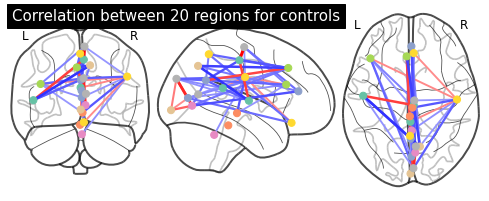

In [17]:
#Plotting the connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlations_adhd, coords,
                         edge_threshold="80%", title='Correlation between 20 regions for ADHD')

plotting.plot_connectome(mean_correlations_control, coords,
                         edge_threshold="80%", title='Correlation between 20 regions for controls')
plotting.show()

In [18]:
#Creating the equivalent interactive visualization
view = plotting.view_connectome(mean_correlations_adhd, coords, edge_threshold='80%')
view

In [19]:
view = plotting.view_connectome(mean_correlations_control, coords, edge_threshold='80%')
view

The Neural Networks Way
We use the correlation matrices of the functional connectivity as input data for our neural network. We build a Sequential model made up of four Dense layers.

In [20]:
#Splitting data into training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(connectivity_biomarkers['correlation'], labels, test_size=0.3)

In [21]:
#Creating the classification model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=connectivity_biomarkers['correlation'].shape[1:]))
#Second  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Third  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

2023-02-02 07:06:02.134516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 07:06:05.109701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
#Compiling the model
classifier.compile(optimizer = Adam(lr =.0001),loss='binary_crossentropy', metrics =['accuracy'])

In [23]:
#Fitting the model
classifier.fit(np.array(X_train),np.array(y_train), batch_size=32, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 656ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5357
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5357
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5357
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5357
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5357
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5357
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5357
Epoch 11/100
1/1 [=========

In [24]:
#Determining accuracy on training
eval_model=classifier.evaluate(np.array(X_train), np.array(y_train))
eval_model

1/1 [==============================] - 0s 120ms/step - loss: 0.6911 - accuracy: 0.5357


[0.6910954117774963, 0.5357142686843872]

In [25]:
#Making the classification and determining accuracy
y_pred=classifier.predict(X_test,batch_size=32)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

1/1 [==============================] - 0s 66ms/step
[[0 7]
 [0 5]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

